In [113]:
using StatsBase, StatsFuns, Distributions, PyPlot, JuMP, Gurobi
include("BernsteinEstimate_MD.jl")
n= 100;
Y = rand(Normal(0,2),n);

In [114]:
a = -10.0
b = 10.0
p = 10

m = 50 + 1

M = Model(solver = GurobiSolver(TimeLimit = 600))

@variable(M, 0<=w[1:m]<=1)
@variable(M, u[1:m,1:m,1:p+1,1:p+1], Bin)

101x101x11x11 Array{JuMP.Variable,4}:
[:, :, 1, 1] =
 u[1,1,1,1]    u[1,2,1,1]    u[1,3,1,1]    …  u[1,100,1,1]    u[1,101,1,1]  
 u[2,1,1,1]    u[2,2,1,1]    u[2,3,1,1]       u[2,100,1,1]    u[2,101,1,1]  
 u[3,1,1,1]    u[3,2,1,1]    u[3,3,1,1]       u[3,100,1,1]    u[3,101,1,1]  
 u[4,1,1,1]    u[4,2,1,1]    u[4,3,1,1]       u[4,100,1,1]    u[4,101,1,1]  
 u[5,1,1,1]    u[5,2,1,1]    u[5,3,1,1]       u[5,100,1,1]    u[5,101,1,1]  
 u[6,1,1,1]    u[6,2,1,1]    u[6,3,1,1]    …  u[6,100,1,1]    u[6,101,1,1]  
 u[7,1,1,1]    u[7,2,1,1]    u[7,3,1,1]       u[7,100,1,1]    u[7,101,1,1]  
 u[8,1,1,1]    u[8,2,1,1]    u[8,3,1,1]       u[8,100,1,1]    u[8,101,1,1]  
 u[9,1,1,1]    u[9,2,1,1]    u[9,3,1,1]       u[9,100,1,1]    u[9,101,1,1]  
 u[10,1,1,1]   u[10,2,1,1]   u[10,3,1,1]      u[10,100,1,1]   u[10,101,1,1] 
 u[11,1,1,1]   u[11,2,1,1]   u[11,3,1,1]   …  u[11,100,1,1]   u[11,101,1,1] 
 u[12,1,1,1]   u[12,2,1,1]   u[12,3,1,1]      u[12,100,1,1]   u[12,101,1,1] 
 u[13,1,1,1]   u[13,2,1

In [115]:
@constraint(M, sum(w)==1)
for j=1:m
    @constraint(M, w[j]==sum{u[j,j,s+1,s+1]*0.5^(s+1), s=0:p})
end
for j=2:m-1
    @constraint(M, sum{sum{0.5^(s+l+2)*u[j,j,s+1,l+1],s=0:p},l=0:p}-sum{sum{0.5^(s+l+2)*u[j-1,j+1,s+1,l+1],s=0:p},l=0:p}>=0) 
end
for i=1:m
    for j=1:m
        for s=1:p+1
            for l=1:p+1
                @constraint(M, u[i,j,s,l]<=u[i,i,s,s])
                @constraint(M, u[i,j,s,l]<=u[j,j,l,l])
                @constraint(M, u[i,j,s,l]>=u[i,i,s,s]+u[j,j,l,l]-1)
            end
        end
    end
end

In [116]:
ϵ = 3/(8*n)
Ecdf = ecdf(Y)

L = zeros(n,n)
B = zeros(n,m)
f = zeros(n,1)
for i = 1:n 
    L[i,i] = (n/((Ecdf(Y[i])+ϵ)*(1+ϵ-Ecdf(Y[i]))))^0.5 
    f[i] = Ecdf(Y[i])
end
for i=1:n
    for j=1:m
        B[i,j] = betacdf(j, m-j+1, (Y[i]-a)/(b-a))
    end
end

@variable(M, r[1:n])
@constraint(M, r.==L*(f-B*w))
 
@objective(M, Min, sum(r.^2))

:Min

In [117]:
tic()
setvalue(w, BernsteinEstimate_MD(Y,m,a,b,1)')
solve(M)
toc()

LoadError: LoadError: Gurobi.GurobiError(10001,"Out of memory")
while loading In[117], in expression starting on line 3

In [118]:
w_hat=getvalue(w)
D = 1000;
x = linspace(a,b,D);
y1 = zeros(D,1);
y1 = y1[:,1];
y2 = zeros(D,1);
y2 = y2[:,1];

for i = 1:D
    y1[i] = pdf(Normal(0,2),x[i]);
    for j = 1:m
        y2[i] = y2[i]+w_hat[j]*betapdf(j, m-j+1, (x[i]-a)/(b-a))/(b-a);
    end
end

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 3703264 rows, 1234522 columns and 8667480 nonzeros
Model has 100 quadratic objective terms
Coefficient statistics:
  Matrix range    [1e-13, 2e+02]
  Objective range [0e+00, 0e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [9e-01, 2e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 3335 rows and 2 columns (presolve time = 7s) ...
Presolve removed 3335 rows and 2 columns (presolve time = 10s) ...
Presolve removed 3335 rows and 2 columns (presolve time = 19s) ...
Presolve removed 3335 rows and 2 columns (presolve time = 20s) ...
Presolve removed 3335 rows and 2 columns (presolve time = 25s) ...
Presolve removed 3335 rows and 2 columns (presolve time = 31s) ...
Presolve removed 3335 rows and 2 columns
Presolve time: 32.39s
Presolved: 3699929 rows, 1234520 columns, 8665526 nonzeros
Presolved model has 10

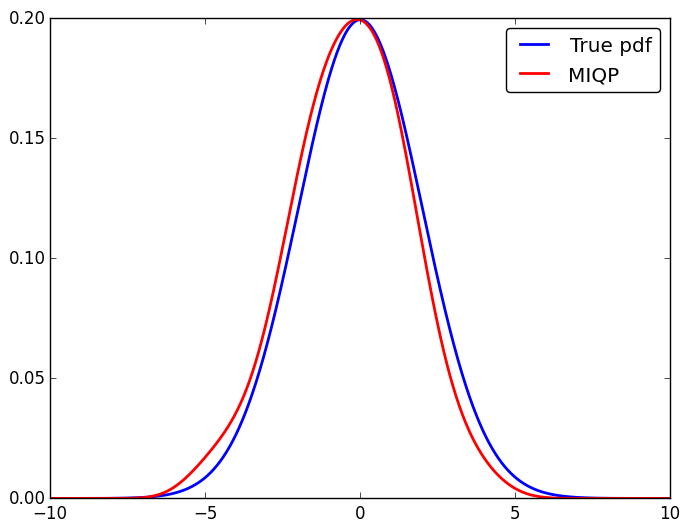

PyObject <matplotlib.legend.Legend object at 0x00000003E05597F0>

In [119]:
plot(x, y1, color="blue", linewidth=2.0, label="True pdf")
plot(x, y2, color="red", linewidth=2.0, label="MIQP")
legend(loc="upper right",fancybox="true")

In [120]:
mean(abs(y1-y2) )

0.005581947294563061